In [1]:
#!pip install --upgrade git+https://github.com/oKatanaaa/GCT

In [2]:
#!pip install --upgrade git+https://github.com/MakiResearchTeam/MakiFlow.git

In [3]:
#%tensorflow_version 1.x

In [1]:
from gct.tools import load_cifar10
import matplotlib.pyplot as plt
from makiflow.core.inference import Model
from makiflow.core.training import Trainer
from makiflow.losses import CustomLoss, CrossEntropy
from makiflow.generators.classification import cycle_generator
import tensorflow as tf
from makiflow.layers import *
import numpy as np
%matplotlib inline

In [2]:
(Xtrain, Ytrain), (Xtest, Ytest), (X_mean, X_std) = load_cifar10()

In [3]:
BATCH_SIZE = 64

In [4]:
def block(x, id, in_f, out_f):
    SX = x
    FX = x
    
    FX = BatchNormLayer(D=in_f, name=f'bn_main_{id}_1')(FX)
    FX = ActivationLayer(name=f'act_1_{id}')(FX)
    FX = ConvLayer(kw=3, kh=3, in_f=in_f, out_f=out_f, name=f'conv_main_{id}_1', activation=None)(FX)
    
    FX = BatchNormLayer(D=out_f, name=f'bn_main_{id}_2')(FX)
    FX = ActivationLayer(name=f'act_2_{id}')(FX)
    FX = ConvLayer(kw=3, kh=3, in_f=out_f, out_f=out_f, name=f'conv_main_{id}_2', activation=None)(FX)

    if in_f != out_f:
        SX = BatchNormLayer(D=in_f, name=f'bn_skip_{id}_1')(SX)
        SX = ConvLayer(kw=1, kh=1, in_f=in_f, out_f=out_f, name=f'conv_skip_{id}', activation=None)(SX)
    
    x_sum = SumLayer(name=f'sum_{id}')([FX, SX])
    return x_sum

In [5]:
# Create a model

In [6]:
inp = InputLayer(input_shape=[None, 32, 32, 3], name='input')
x = block(inp, id=1, in_f=3, out_f=32)
x = MaxPoolLayer(name='mp1')(x)
# 16x16
x = block(x, id=2, in_f=32, out_f=64)
x = block(x, id=3, in_f=64, out_f=64)
x = MaxPoolLayer(name='mp2')(x)
# 8x8
x = block(x, id=4, in_f=64, out_f=128)
x = block(x, id=5, in_f=128, out_f=128)
x = MaxPoolLayer(name='mp3')(x)
# 4x4
x = block(x, id=6, in_f=128, out_f=256)
x = block(x, id=7, in_f=256, out_f=256)
x = MaxPoolLayer(name='mp4')(x)
# 2x2
x = FlattenLayer('flat')(x)
# 4*256 = 1024
x_f = DenseLayer(in_d=1024, out_d=256, name='projection_head')(x)
# Head1
x = DenseLayer(in_d=256, out_d=10, activation=None, name='classification_head1')(x_f)
x = ConcatLayer(name='concat1', axis=-1)([x, x_f])

# Head2
x = DenseLayer(in_d=266, out_d=10, activation=None, name='classification_head2')(x)
x = ConcatLayer(name='concat2', axis=-1)([x, x_f])

x = DenseLayer(in_d=266, out_d=10, activation=None, name='classification_head3')(x)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [7]:
model = Model(inputs=[inp], outputs=[x], name='MakiResNet')
sess = tf.Session()
model.set_session(sess)

In [8]:
# Setup training

In [9]:
loss1 = CrossEntropy(
    tensor_names=['classification_head1', 'classification_head2', 'classification_head3'], 
    label_tensors={CrossEntropy.LABELS: tf.placeholder(dtype='int32', shape=[BATCH_SIZE])}
)

In [10]:
loss1 = loss1 * 2 + loss1 / 3 + (loss1 + 1)

In [11]:
trainer = Trainer(model, [InputLayer(input_shape=[BATCH_SIZE, 32, 32, 3], name='input')], loss1)
# training_inputs - list, can contain generators

In [12]:
trainer.compile()


build!

Loss is built.


In [13]:
opt = tf.train.AdamOptimizer()

In [14]:
gen = cycle_generator(Xtrain, Ytrain.reshape(-1), BATCH_SIZE)

In [15]:
info1 = trainer.fit_generator(gen, optimizer=opt, epochs=5, iter=100, print_period=10)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

New optimizer is used.


 17%|█████████████▊                                                                   | 17/100 [00:04<00:09,  8.68it/s]

Epoch: 0
Training_Loss: 42.8060092 




 25%|████████████████████▎                                                            | 25/100 [00:04<00:04, 15.42it/s]

Epoch: 0
Training_Loss: 28.5560543 




 37%|█████████████████████████████▉                                                   | 37/100 [00:04<00:02, 26.15it/s]

Epoch: 0
Training_Loss: 22.2327937 




 45%|████████████████████████████████████▍                                            | 45/100 [00:05<00:01, 31.57it/s]

Epoch: 0
Training_Loss: 19.7589571 




 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:05<00:01, 36.07it/s]

Epoch: 0
Training_Loss: 18.3795955 




 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:05<00:00, 37.55it/s]

Epoch: 0
Training_Loss: 17.5884939 




 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:05<00:00, 38.68it/s]

Epoch: 0
Training_Loss: 17.2478689 




 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:06<00:00, 38.79it/s]

Epoch: 0
Training_Loss: 17.1002449 




 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:06<00:00, 38.52it/s]

Epoch: 0
Training_Loss: 16.5580805 




  4%|███▎                                                                              | 4/100 [00:00<00:02, 38.45it/s]

Epoch: 0
Training_Loss: 15.7949265 




 16%|████████████▉                                                                    | 16/100 [00:00<00:02, 39.00it/s]

Epoch: 1
Training_Loss: 15.3077262 




 28%|██████████████████████▋                                                          | 28/100 [00:00<00:01, 39.19it/s]

Epoch: 1
Training_Loss: 15.2820227 




 36%|█████████████████████████████▏                                                   | 36/100 [00:00<00:01, 38.89it/s]

Epoch: 1
Training_Loss: 15.0596972 




 48%|██████████████████████████████████████▉                                          | 48/100 [00:01<00:01, 38.84it/s]

Epoch: 1
Training_Loss: 15.1788751 




 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:01<00:01, 38.87it/s]

Epoch: 1
Training_Loss: 14.7129321 




 68%|███████████████████████████████████████████████████████                          | 68/100 [00:01<00:00, 39.00it/s]

Epoch: 1
Training_Loss: 14.7990994 




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:01<00:00, 38.98it/s]

Epoch: 1
Training_Loss: 14.3550813 




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:02<00:00, 38.75it/s]

Epoch: 1
Training_Loss: 14.0544248 




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:02<00:00, 35.21it/s]

Epoch: 1
Training_Loss: 13.7112758 




  4%|███▎                                                                              | 4/100 [00:00<00:02, 38.45it/s]

Epoch: 1
Training_Loss: 14.0978075 




 16%|████████████▉                                                                    | 16/100 [00:00<00:02, 38.53it/s]

Epoch: 2
Training_Loss: 13.6114273 




 24%|███████████████████▍                                                             | 24/100 [00:00<00:01, 38.92it/s]

Epoch: 2
Training_Loss: 13.5378004 




 36%|█████████████████████████████▏                                                   | 36/100 [00:00<00:01, 34.64it/s]

Epoch: 2
Training_Loss: 13.5945684 




 44%|███████████████████████████████████▋                                             | 44/100 [00:01<00:01, 33.75it/s]

Epoch: 2
Training_Loss: 13.6234914 




 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:01<00:01, 35.68it/s]

Epoch: 2
Training_Loss: 13.9888133 




 68%|███████████████████████████████████████████████████████                          | 68/100 [00:01<00:00, 37.75it/s]

Epoch: 2
Training_Loss: 13.3036468 




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:02<00:00, 38.14it/s]

Epoch: 2
Training_Loss: 12.9644288 




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:02<00:00, 38.50it/s]

Epoch: 2
Training_Loss: 12.9675207 




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:02<00:00, 38.87it/s]

Epoch: 2
Training_Loss: 12.9652511 




  8%|██████▌                                                                           | 8/100 [00:00<00:02, 39.76it/s]

Epoch: 2
Training_Loss: 12.9880639 




 16%|████████████▉                                                                    | 16/100 [00:00<00:02, 39.65it/s]

Epoch: 3
Training_Loss: 12.9391947 




 28%|██████████████████████▋                                                          | 28/100 [00:00<00:01, 39.43it/s]

Epoch: 3
Training_Loss: 13.2679341 




 36%|█████████████████████████████▏                                                   | 36/100 [00:00<00:01, 39.14it/s]

Epoch: 3
Training_Loss: 12.3171620 




 48%|██████████████████████████████████████▉                                          | 48/100 [00:01<00:01, 39.12it/s]

Epoch: 3
Training_Loss: 12.3034509 




 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:01<00:01, 39.09it/s]

Epoch: 3
Training_Loss: 12.3748316 




 68%|███████████████████████████████████████████████████████                          | 68/100 [00:01<00:00, 38.94it/s]

Epoch: 3
Training_Loss: 12.3896023 




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:01<00:00, 38.96it/s]

Epoch: 3
Training_Loss: 11.9482945 




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:02<00:00, 39.12it/s]

Epoch: 3
Training_Loss: 11.7493115 




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:02<00:00, 39.08it/s]

Epoch: 3
Training_Loss: 11.6089257 




  4%|███▎                                                                              | 4/100 [00:00<00:02, 39.59it/s]

Epoch: 3
Training_Loss: 11.7322663 




 16%|████████████▉                                                                    | 16/100 [00:00<00:02, 39.20it/s]

Epoch: 4
Training_Loss: 11.6369249 




 24%|███████████████████▍                                                             | 24/100 [00:00<00:02, 36.57it/s]

Epoch: 4
Training_Loss: 11.3894060 




 36%|█████████████████████████████▏                                                   | 36/100 [00:00<00:01, 38.33it/s]

Epoch: 4
Training_Loss: 11.7362389 




 44%|███████████████████████████████████▋                                             | 44/100 [00:01<00:01, 38.71it/s]

Epoch: 4
Training_Loss: 11.4143902 




 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:01<00:01, 39.01it/s]

Epoch: 4
Training_Loss: 11.4583972 




 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:01<00:00, 39.00it/s]

Epoch: 4
Training_Loss: 11.1564645 




 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:01<00:00, 38.91it/s]

Epoch: 4
Training_Loss: 11.2102985 




 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:02<00:00, 38.88it/s]

Epoch: 4
Training_Loss: 11.5195826 




 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:02<00:00, 38.97it/s]

Epoch: 4
Training_Loss: 11.1565648 




100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.66it/s]

Epoch: 4
Training_Loss: 11.2890230 




In [16]:
predictions = model.predict(Xtest)

10000it [00:27, 358.47it/s]


In [17]:
predictions = np.argmax(predictions, axis=-1)

In [18]:
np.mean(predictions == Ytest.reshape(-1))

0.582

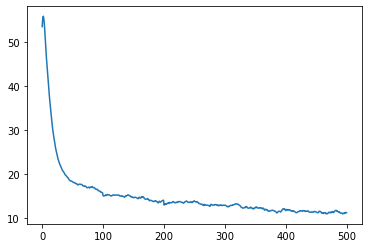

In [19]:
plt.plot(info1[trainer.TRAINING_LOSS])